# Graph Cut search problem with Grover Oracle

## Introduction

The "Maximum Cut Problem" (MaxCut) [[1](#MaxCutWiki)] is an example of combinatorial optimization problem. It refers to finding a partition of a graph into two sets, such that the number of edges between the two sets is maximal.

## Mathematical formulation

Given a graph $G=(V,E)$ with $|V|=n$ nodes and $E$ edges, a cut is defined as a partition of the graph into two complementary subsets of nodes. In the MaxCut problem we are looking for a cut where the number of edges between the two subsets is maximal. We can represent a cut of the graph by a binary vector $x$ of size $n$, where we assign 0 and 1 to nodes in the first and second subsets, respectively. The number of connecting edges for a given cut is simply given by summing over $x_i (1-x_j)+x_j (1-x_i)$ for every pair of connected nodes $(i,j)$.

# Solving with the Classiq platform


In this tutorial we define a **search problem** instead: Given a graph and number of edges, check if there is a cut in the graph larger than a certain size. We will solve the problem using the grover algorithm.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pyomo.core as pyo
import sympy
from IPython.display import Markdown, display

### Define the cut search problem

We will use sympy in order to create an formula for the cut, later to be used within the quantum algorithm.

In [2]:
def is_cross_cut_edge(x1: int, x2: int) -> int:
    return x1 * (1 - x2) + x2 * (1 - x1)


def generate_cut_formula(graph: nx.Graph):
    x = sympy.symbols(f"x:{len(graph.nodes)}")
    expr = sum(is_cross_cut_edge(x[node1], x[node2]) for (node1, node2) in graph.edges)
    expr = sympy.simplify(expr)
    print("Graph cut expression:", expr)
    formula_func = sympy.lambdify(x, expr)
    return formula_func

### Define a speific problem input

We will initiate a specific graph, whose maximum cut is 5:

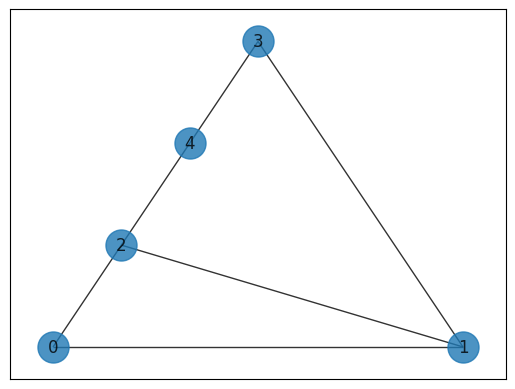

In [3]:
# Create graph
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)])
pos = nx.planar_layout(G)
nx.draw_networkx(G, pos=pos, with_labels=True, alpha=0.8, node_size=500)

In [4]:
cut_formula = generate_cut_formula(G)

Graph cut expression: -2*x0*x1 - 2*x0*x2 + 2*x0 - 2*x1*x2 - 2*x1*x3 + 3*x1 - 2*x2*x4 + 3*x2 - 2*x3*x4 + 2*x3 + 2*x4


## Creating quantum circuit from the problem formulation and solving it using the Classiq platform

We use the `grover_search` function for the quantum circuit. The oracle function will be a `phase_oracle`, which applies a $(-1)$ phase to each state that the inner function delivered to `phase_oracle` returns 1 for. The `cut_oracle` is the inner function in this case - calculating whether a given graph partition`s cut is larger than some constant.


here we look for a cut of size 4 to the graph:

In [5]:
from classiq import *

CUT_SIZE = 4


@qfunc
def cut_oracle(cut_size: CInt, nodes: QArray[QBit], res: QBit):
    res ^= -(cut_formula(*[nodes[i] for i in range(len(G.nodes))])) <= -cut_size


@qfunc
def main(nodes: Output[QArray[QBit, len(G.nodes)]]):
    allocate(nodes.len, nodes)
    grover_search(
        reps=3,
        oracle=lambda vars: phase_oracle(
            lambda vars, res: cut_oracle(CUT_SIZE, vars, res), vars
        ),
        packed_vars=nodes,
    )


qmod = create_model(main)
qmod = set_constraints(qmod, max_width=22)
write_qmod(qmod, "grover_max_cut")

## Synthesizing the Circuit

We proceed by synthesizing the circuit using Classiq's synthesis engine. The synthesis should take approximately several seconds:

In [8]:
qprog = synthesize(qmod)

## Showing the Resulting Circuit

After Classiq's synthesis engine has finished the job, we can show the resulting circuit in the interactive GUI:

In [9]:
show(qprog)

In [10]:
circuit = QuantumProgram.from_qprog(qprog)

print(circuit.transpiled_circuit.depth)

2399


### Execute the problem on a simulator and try to find a valid solution
Lastly, we can execute the resulting circuit with Classiq's execute interface, using the `execute` function.

In [11]:
optimization_result = execute(qprog).result_value()

Printing out the result, we see that our execution of Grover's algorithm successfully found the satisfying assignments for the input formula:

In [13]:
optimization_result.parsed_counts

[{'nodes': [1, 0, 0, 1, 1]}: 85,
 {'nodes': [0, 1, 0, 0, 1]}: 79,
 {'nodes': [0, 1, 1, 0, 1]}: 75,
 {'nodes': [0, 1, 1, 1, 0]}: 75,
 {'nodes': [0, 1, 1, 0, 0]}: 74,
 {'nodes': [1, 0, 0, 1, 0]}: 72,
 {'nodes': [0, 0, 1, 1, 0]}: 72,
 {'nodes': [1, 0, 1, 1, 0]}: 69,
 {'nodes': [1, 0, 0, 0, 1]}: 64,
 {'nodes': [1, 1, 0, 0, 1]}: 56,
 {'nodes': [1, 1, 0, 1, 1]}: 19,
 {'nodes': [0, 0, 0, 0, 1]}: 18,
 {'nodes': [0, 0, 1, 0, 0]}: 16,
 {'nodes': [0, 1, 1, 1, 1]}: 16,
 {'nodes': [0, 0, 0, 1, 0]}: 15,
 {'nodes': [1, 0, 1, 1, 1]}: 15,
 {'nodes': [1, 0, 1, 0, 0]}: 14,
 {'nodes': [1, 0, 0, 0, 0]}: 14,
 {'nodes': [1, 1, 1, 1, 0]}: 14,
 {'nodes': [1, 1, 1, 0, 0]}: 13,
 {'nodes': [1, 1, 1, 0, 1]}: 13,
 {'nodes': [1, 0, 1, 0, 1]}: 12,
 {'nodes': [0, 1, 0, 1, 0]}: 11,
 {'nodes': [1, 1, 0, 1, 0]}: 11,
 {'nodes': [0, 0, 0, 1, 1]}: 11,
 {'nodes': [0, 0, 0, 0, 0]}: 11,
 {'nodes': [0, 1, 0, 1, 1]}: 10,
 {'nodes': [0, 0, 1, 1, 1]}: 10,
 {'nodes': [0, 1, 0, 0, 0]}: 10,
 {'nodes': [1, 1, 1, 1, 1]}: 9,
 {'nodes': 

We can see that the satisfying assignments are ~6 times more probable than the unsatisfying assignments. Let's print one of them:

In [14]:
most_probable_result = optimization_result.parsed_counts[0]

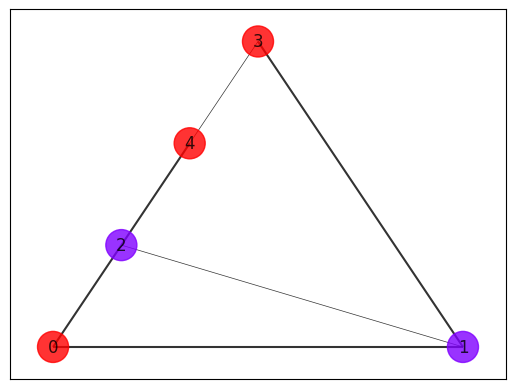

In [15]:
result_parsed = most_probable_result.state["nodes"]
edge_widths = [
    is_cross_cut_edge(
        int(result_parsed[i]),
        int(result_parsed[j]),
    )
    + 0.5
    for i, j in G.edges
]
node_colors = [int(c) for c in result_parsed]
nx.draw_networkx(
    G,
    pos=pos,
    with_labels=True,
    alpha=0.8,
    node_size=500,
    node_color=node_colors,
    width=edge_widths,
    cmap=plt.cm.rainbow,
)


## References

<a id='MaxCutWiki'>[1]</a>: [Maximum Cut Problem (Wikipedia)](https://en.wikipedia.org/wiki/Maximum_cut)
